


# Numerical accuracy of uvcontsub2021

This notebook is to simulate MeasurementSets with known continuum shapes (as polynomials of different order). It has functions to produce MSs including  point sources, spectral lines, noise, and polynomial continuum functions. These MSs can be used to illustrate the numerical accuracy of the task uvcontsub2021 under different simulated conditions. 




# Preparations. Installs and imports.


## Install required packages

In [553]:
if 'google.colab' in str(get_ipython()):
  import sys
  print(f'Running in colab, Python version {sys.version}')
  import os
  print("installing pre-requisite packages...")
  os.system("apt-get install libgfortran3")
  # Use wheels from CAS-13631 or CAS-13686 => nope (cp36)
  # !pip --verbose install https://open-bamboo.nrao.edu/browse/CASA-C6B502-1/artifact/shared/Tool-wheel/casatools-6.4.3.8a13631.dev1-cp36-cp36m-manylinux2010_x86_64.whl
  # https://open-bamboo.nrao.edu/browse/CASA-C6B502-1/artifact/shared/Task-wheel/casatasks-6.4.3.8a13631.dev1-py3-none-any.whl
  print("installing casatasks...")
  os.system("pip install --extra-index-url --index-url=https://go.nrao.edu/pypi casatasks")

  print("installing casadata...")
  os.system("pip install --extra-index-url --index-url=https://go.nrao.edu/pypi casadata")


In [554]:
!ls -l /usr/local/lib/python3.7/dist-packages/casatools-6.4.0.16.dist-info
!cat /usr/local/lib/python3.7/dist-packages/casatools-6.4.0.16.dist-info/WHEEL


ls: cannot access '/usr/local/lib/python3.7/dist-packages/casatools-6.4.0.16.dist-info': No such file or directory
cat: /usr/local/lib/python3.7/dist-packages/casatools-6.4.0.16.dist-info/WHEEL: No such file or directory


## Import required CASA tasks and tools, and other packages

In [555]:
from casatools import componentlist, ctsys, measures, simulator, table
from casatasks import flagdata, listobs
from casatasks.private import simutil
import numpy as np
import glob
import os, shutil

cl = componentlist()
sm = simulator()

In [556]:
# Some checks - TODO - remove
from casatools import ctsys
ctsys.getpath()
ctsys.resolve('alma/simmos')

'/home/fedemp/casa-CAS-13631-3/lib/py/lib/python3.6/site-packages/casadata/__data__/alma/simmos'

# Definition of simulation building blocks
Uses functions from https://github.com/urvashirau/Simulation-in-CASA/blob/master/Basic_Simulation_Demo/Simulation_Script_Demo.ipynb, adapted to this set of simulations for uvcontsub.

## Make MS structure

In [557]:
def make_ms_frame(msname, ant_config, spw_params=None):
    """ 
    Construct an empty MeasurementSet that has the desired observation setup. 

    ant_config: from casadata (alma/simmos) (for example  alma/simmos/aca.cycle8.cfg)
    """ 
    ## Open the simulator
    sm.open(ms=msname);

    ## Read/create an antenna configuration. 
    ## Canned antenna config text files are located here: <casadata>/alma/simmos/*cfg
    antennalist = os.path.join(ctsys.resolve("alma/simmos"), ant_config)
    verbose = False
    if verbose:
      print(f'Using antenna list file: {antennalist}')
    
    ## Fictitious telescopes can be simulated by specifying x, y, z, d, an, telname, antpos.
    ##     x,y,z are locations in meters in ITRF (Earth centered) coordinates. 
    ##     d, an are lists of antenna diameter and name.
    ##     telname and obspos are the name and coordinates of the observatory. 
    mysu = simutil.simutil()
    (x,y,z,d,an,an2,telname, obspos) = mysu.readantenna(antennalist)

    ## Set the antenna configuration
    metool = measures()
    sm.setconfig(telescopename=telname,
                     x=x,
                     y=y,
                     z=z,
                     dishdiameter=d,
                     mount=['alt-az'], 
                     antname=an,
                     coordsystem='local',
                     referencelocation=metool.observatory(telname));

    ## Set the polarization mode (this goes to the FEED subtable)
    sm.setfeed(mode='perfect X Y', pol=['']);    # X Y / R L

    ## Set the spectral window and polarization (one data-description-id). 
    ## Call multiple times with different names for multiple SPWs or pol setups.
    sm.setspwindow(spwname=spw_params['name'],
                   freq=spw_params['freq'],
                   deltafreq='0.1GHz',
                   freqresolution='0.2GHz',
                   nchannels=spw_params['nchan'],
                   stokes='XX YY');

    ## Setup source/field information (i.e. where the observation phase center is)
    ## Call multiple times for different pointings or source locations.
    source_name = 'simulated_source'
    sm.setfield(sourcename=source_name,
                sourcedirection=metool.direction(rf='J2000',
                                                 v0='19h59m28.5s',v1='+40d44m01.5s'));

    ## Set shadow/elevation limits (if you care). These set flags.
    sm.setlimits(shadowlimit=0.01, elevationlimit='1deg');

    ## Leave autocorrelations out of the MS.
    sm.setauto(autocorrwt=0.0);  

    ## Set the integration time, and the convention to use for timerange specification
    ## Note : It is convenient to pick the hourangle mode as all times specified in sm.observe()
    ##        will be relative to when the source transits.
    sm.settimes(integrationtime='2s',
                usehourangle=True,
                referencetime=metool.epoch('UTC','2021/10/14/00:01:02'));

    ## Construct MS metadata and UVW values for one scan and ddid 
    ## Call multiple times for multiple scans.
    ## Call this with different sourcenames (fields) and spw/pol settings as defined above.
    ## Timesteps will be defined in intervals of 'integrationtime', between starttime and stoptime.
    sm.observe(sourcename=source_name,
               spwname=spw_params['name'],
               starttime='0', 
               stoptime='+8s');

    ## Close the simulator
    sm.close()
    
    ## Unflag everything (unless you care about elevation/shadow flags)
    flagdata(vis=msname, mode='unflag', flagbackup=False)

## Plotting of visibilities and uv coverage

In [558]:
def plot_ms_data(msname='sim_data.ms', myplot='uv', plot_complex='abs'):
    """
    Options : myplot='uv'
              myplot='data_spectrum'
  Args:
      plot_complex: 'abs', 'real', or 'imag'
    """
    from casatools import table
    import pylab as pl
    import numpy as np

    tb = table()
    from matplotlib.collections import LineCollection
    tb.open(msname)

    # UV coverage plot
    if myplot=='uv':
        pl.figure(figsize=(4,4))
        pl.clf()
        uvw = tb.getcol('UVW')
        pl.plot( uvw[0], uvw[1], '.')
        pl.plot( -uvw[0], -uvw[1], '.')
        pl.title('UV Coverage')
    
    # Spectrum of chosen column. Make a linecollection out of each row in the MS.
    if myplot=='data_spectrum' or myplot=='corr_spectrum' or myplot=='resdata_spectrum'  or myplot=='rescorr_spectrum' or myplot=='model_spectrum':
        dats=None
        if myplot=='data_spectrum':
            dats = tb.getcol('DATA')
        if myplot=='corr_spectrum':
            dats = tb.getcol('CORRECTED_DATA')
        if myplot=='resdata_spectrum':
            dats = tb.getcol('DATA') - tb.getcol('MODEL_DATA') 
        if myplot=='rescorr_spectrum':
            dats = tb.getcol('CORRECTED_DATA') - tb.getcol('MODEL_DATA') 
        if myplot=='model_spectrum':
            dats = tb.getcol('MODEL_DATA')
            
        xs = np.zeros((dats.shape[2],dats.shape[1]),'int')
        for chan in range(0,dats.shape[1]):
            xs[:,chan] = chan
    
        npl = dats.shape[0]
        fig, ax = pl.subplots(1,npl,figsize=(10,4))
        
        if plot_complex == 'abs':
            complex_func = np.abs
        elif plot_complex == 'real':
            complex_func = np.real
        elif plot_complex == 'imag':
            complex_func = np.imag
        else:
            raise ValueError(f'Invalid plot_complex: {plot_complex}')
        
        for pol in range(0,dats.shape[0]):
            x = xs
            y = complex_func(dats[pol,:,:]).T 
            data = np.stack(( x,y ), axis=2)
            ax[pol].add_collection(LineCollection(data))
            ax[pol].set_title(myplot + ' \n pol '+str(pol))
            ax[pol].set_xlim(x.min(), x.max())
            ax[pol].set_ylim(y.min(), y.max())
        pl.show()

## Update visibilities
Manipulate visibilities, adding components (as in the components tool), noise, spectral lines, polynomials, etc.

In [559]:
def add_ms_gaussian_noise(ms_name, noise_level_sigma='0.1Jy'):
   """Adds Gaussian random noise using simulator / corrupt"""
   try:
      sm.openfromms(ms_name)
      sm.setseed(4321)
      sm.setnoise(mode='simplenoise', simplenoise=noise_level_sigma)
      sm.corrupt()
   finally:
      sm.close()

In [560]:
def make_point_source_comp_list(cl_name, freq, spectrumtype, flux):
  try:
    cl.addcomponent(dir='J2000 19h59m28.5s +40d44m01.5s', 
                    flux=flux,
                    fluxunit='Jy', 
                    freq=freq,
                    shape='point',
                    # shape='gaussian',
                    # majoraxis="5.0arcmin", 
                    # minoraxis='2.0arcmin',
                    # polarization='linear', / 'Stokes'
                    # spectrumtype:'spectral index' / 'constant'
                    spectrumtype=spectrumtype,
                    index=-3.0,
                    label='sim_point_source')
    cl.rename(filename=cl_name)
  finally:
    cl.close()

In [561]:
def sim_from_comp_list(ms_name, cl_name):
  """
  Updates the MS visibilities using simulator.predict to add
  components from the components list
  
  Args:
      ms_name: MS to modify
      cl_name: name of components list file to simulate
  """
  try:
     sm.openfromms(ms_name)
     sm.predict(complist=cl_name, incremental=False)
  finally:
     sm.close()

In [562]:
def add_point_source_component(ms_name, freq=None, spectrumtype='constant', 
                               flux=5.0):
  """
  Makes a component list...
  
  Args:
      ms_name: MS to modify
      freq: 
      spectrumtype: 
      flux: In Jy, as used in componentlist.addcomponent
  """
  cl_name = 'sim_point_source.cl'
  make_point_source_comp_list(cl_name=cl_name, freq=freq, 
                              spectrumtype=spectrumtype, flux=flux)
  sim_from_comp_list(ms_name, cl_name)
  shutil.rmtree(cl_name)


In [563]:
def add_spectral_line(ms_name, chan_range=[60,86], amp_factor=None):
  """Adds a spectral line as a Gaussian function in the range 
  of channels given
  
  Args:
      ms_name: MS to modify
      chan_range: list with indices of the first and last channel
      amp_factor: factor to multiply the peak height / flux density
  """
  try:
    tbtool = table()
    tbtool.open(ms_name, nomodify=False)
    data = tbtool.getcol('DATA')

    def gauss(x, mu, sigma):
      return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))
    x = np.linspace(-3, 3, chan_range[1]-chan_range[0])
    bell_line = gauss(x, 0, 0.58)

    ## Add same gaussian to real and imag part
    # data has indices pol:chan:time
    if not amp_factor:
      amp_factor = 1.0/np.max(bell_line)
    data[:,chan_range[0]:chan_range[1],:] +=\
      amp_factor * (1+0j) * bell_line.reshape((1, len(bell_line),1))

    tbtool.putcol('DATA', data)
  finally:
    tbtool.done()

In [564]:
def add_polynomial_cont(ms_name, pol_coeff, nchan, amp_factor=1.0):
  """
  Update MS visibilities adding a polynomial evaluated for all channels.
  
  Args:
      ms_name: MS to modify
      pol_coeff: polynomial coefficients, evaluated [0.5, 0.25] => 0.5x + 0.25
      nchan: number of channels in the SPW (x axis to eval polynomial)
  """
  try:
    tbtool = table()
    tbtool.open(ms_name, nomodify=False)
    data = tbtool.getcol('DATA')

    x = np.linspace(0, 1, nchan)
    polynomial = np.polyval(pol_coeff, x)
    # Add same polynomial to real and imag part
    data += amp_factor * (1+1j) * polynomial.reshape((1, len(polynomial),1))

    tbtool.putcol('DATA', data)
  finally:
    tbtool.done()

# Produce simulated datasets - for task verfication test

In [565]:
def make_test_ms_alma_verif(ms_name, noise_sigma='0.1Jy', pol_coeffs=[0.5], 
                      verbose=True):
  """
  Adds a point source, a spectral line, noise, and a continuum as a polynomial

  Args:
      noise_sigma: sigma for the Gaussian noise, set to None for no noise
      pol_coeffs: coefficients of the cont polynomial, ordered from higher to 
                  lower order
      verbose: print and plot what is being done
  """
  ant_config = 'alma.cycle8.8.cfg'
  spw_params = {'name': "Simulated_Band",
                'freq': '150GHz',
                'nchan': 128}

  make_ms_frame(ms_name, ant_config=ant_config, spw_params=spw_params)

  add_point_source_component(ms_name, freq='100GHz', spectrumtype='constant', 
                             flux=0.5)
  if verbose:
    print('Data plots. Only point source:')
    plot_ms_data(ms_name, 'data_spectrum')

  add_spectral_line(ms_name, chan_range=[60,86])
  if verbose:
    print('Data plots, + spectral line, width ~20% band:')
    plot_ms_data(ms_name, 'data_spectrum')

  # polynomial order 0,1,2,3 around 0.5Jy
  add_polynomial_cont(ms_name, pol_coeffs, spw_params['nchan'])    
  if verbose:
    print('Data plots + polynomial cont:')
    plot_ms_data(ms_name, 'data_spectrum')

  if noise_sigma:
    add_ms_gaussian_noise(ms_name, noise_sigma)
    if verbose:
      print('Data plots + Gaussian noise:')
      plot_ms_data(ms_name, 'data_spectrum')

## Simple MS step by step

Using order 0 continuum.

The structure of this MS is the one used at the moment in the task test (test_task_req_uvcontsub2021). nchan=128. The spectral line is added to channels 60-85.
The fitspw for this would be '0:0\~59;86\~127'

Data plots. Only point source:


/home/fedemp/casa-CAS-13631-3/lib/py/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Attempting to set identical bottom == top == 0.5 results in singular transformations; automatically expanding.


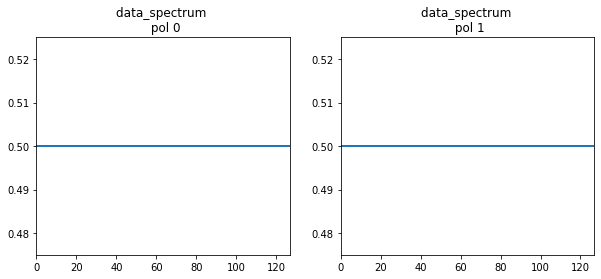

Data plots, + spectral line, width ~20% band:


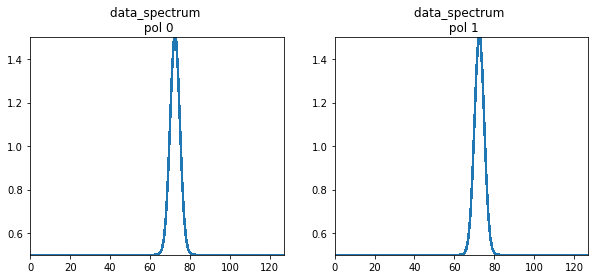

Data plots + polynomial cont:


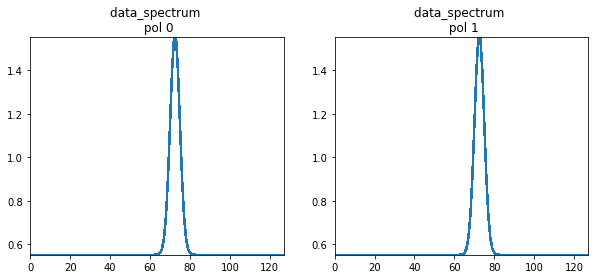

Data plots + Gaussian noise:


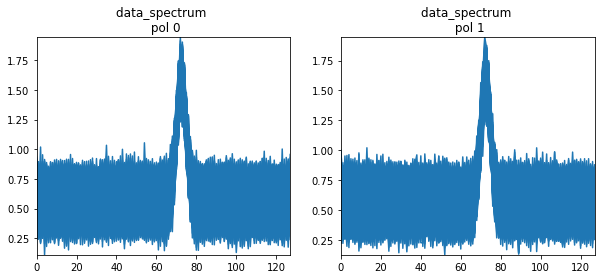

In [566]:
os.system('rm -rf example_sim_*.ms sim_*.ms')

ms_name = 'example_sim_alma_noise_cont_poly_order_0.ms'
make_test_ms_alma_verif(ms_name, pol_coeffs=[0.05], verbose=True)


## Some more simple test MSs

Plotting no-noise MS, with continuum as polynomial order 1


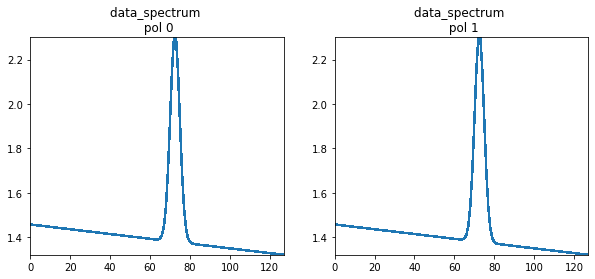

In [567]:
# Still make a trivial order 0 without noise, for the most basic verif test
ms_name = 'example_sim_alma_nonoise_cont_poly_order_0.ms'
make_test_ms_alma_verif(ms_name, pol_coeffs=[0.5], noise_sigma=None, verbose=False)

ms_name = 'example_sim_alma_nonoise_cont_poly_order_1.ms'
make_test_ms_alma_verif(ms_name, pol_coeffs=[-0.1, 0.75], noise_sigma=None, verbose=False)
print('Plotting no-noise MS, with continuum as polynomial order 1')
plot_ms_data(ms_name, 'data_spectrum')

total 5856
-rw-rw-r--  1 fedemp fedemp   23625 Oct 22 15:42 cal_library_syntax.ipynb
-rw-rw-r--  1 fedemp fedemp   13101 Jan 14 17:26 carta.ipynb
-rw-rw-r--  1 fedemp fedemp 1221125 Jan 16 18:16 casa-20220116-153923.log
-rw-rw-r--  1 fedemp fedemp 2476328 Jan 17 14:35 casa-20220117-090517.log
-rw-rw-r--  1 fedemp fedemp  130050 Jan 14 17:26 casa-fundamentals.ipynb
-rw-rw-r--  1 fedemp fedemp  244114 Jan 14 17:26 data_examination.ipynb
-rw-rw-r--  1 fedemp fedemp    5965 Oct 22 15:42 data_weights.ipynb
-rw-rw-r--  1 fedemp fedemp   19002 Oct 22 15:42 ephemeris_data.ipynb
drwxrwxr-x 15 fedemp fedemp    4096 Jan 17 14:35 example_sim_alma_noise_cont_poly_order_0.ms
drwxrwxr-x 15 fedemp fedemp    4096 Jan 17 14:35 example_sim_alma_nonoise_cont_poly_order_0.ms
drwxrwxr-x 15 fedemp fedemp    4096 Jan 17 14:35 example_sim_alma_nonoise_cont_poly_order_1.ms
-rw-rw-r--  1 fedemp fedemp   23242 Nov  1 17:11 external-data.ipynb
-rw-rw-r--  1 fedemp fedemp  301930 Jan 16 18:02 image_analysis.ipynb
-

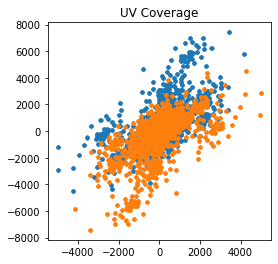

In [568]:
!ls -l
!du -hsc *.ms
plot_ms_data(ms_name, 'uv')

In [569]:
from casatasks import listobs
res = listobs(vis=ms_name)
import pprint
pprint.pprint(res)
print(res)

{'BeginTime': 59500.80211451902,
 'EndTime': 59500.802207111614,
 'IntegrationTime': 8.0,
 'field_0': {'code': '',
             'direction': {'m0': {'unit': 'rad', 'value': -1.0494882958398402},
                           'm1': {'unit': 'rad', 'value': 0.7109380541842404},
                           'refer': 'J2000',
                           'type': 'direction'},
             'name': 'simulated_source'},
 'nfields': 1,
 'numrecords': 3612,
 'scan_1': {'0': {'BeginTime': 59500.80211451902,
                  'EndTime': 59500.802207111614,
                  'FieldId': 0,
                  'FieldName': 'simulated_source',
                  'IntegrationTime': 2.0,
                  'SpwIds': array([0]),
                  'StateId': 0,
                  'nRow': 3612,
                  'scanId': 1}},
 'timeref': 'UTC'}
{'BeginTime': 59500.80211451902, 'EndTime': 59500.802207111614, 'IntegrationTime': 8.0, 'field_0': {'code': '', 'direction': {'m0': {'unit': 'rad', 'value': -1.04948829583984

## Higher order polynomials


Plotting polynomial order 0:


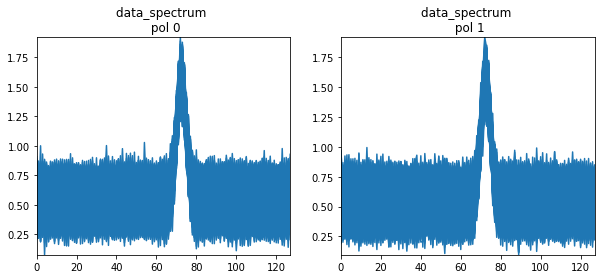

Plotting polynomial order 1:


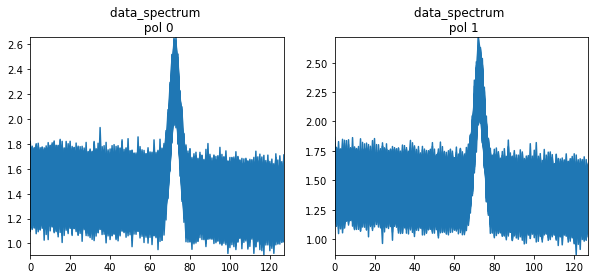

Plotting polynomial order 2:


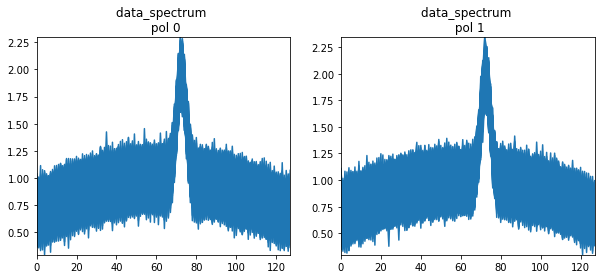

Plotting polynomial order 3:


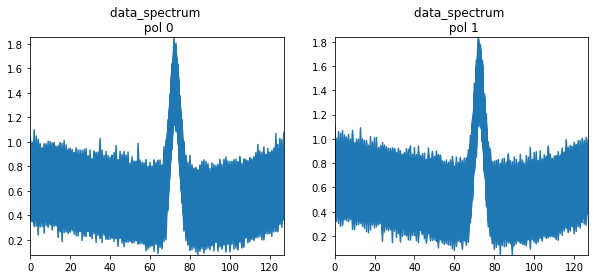

In [570]:
# Giving coefficients as [0.1, 0.45] == 0.1x + 0.45
polynomials = {0: [0.025],
               1: [-0.1, 0.75],
               2: [-1, 1, 0.15],
               3: [1, -0.75, -0.25, 0.15]
               # Order 3 could also be of the style (not sure what type we want): 
               # [-1.35, 0, 1.5, 0.2]
}
for order, poly in polynomials.items():
  ms_name = f'sim_alma_cont_poly_order_{order}_nonoise.ms'
  os.system('rm -rf sim_*.cl')
  make_test_ms_alma_verif(ms_name, pol_coeffs=poly, noise_sigma=None, verbose=False)

  ms_name = f'sim_alma_cont_poly_order_{order}_noise.ms'
  os.system('rm -rf sim_*.cl')
  make_test_ms_alma_verif(ms_name, pol_coeffs=poly, verbose=False)
  print(f'Plotting polynomial order {order}:')
  plot_ms_data(ms_name, 'data_spectrum')

In [571]:
!du -hsc *.ms

35M	example_sim_alma_noise_cont_poly_order_0.ms
35M	example_sim_alma_nonoise_cont_poly_order_0.ms
35M	example_sim_alma_nonoise_cont_poly_order_1.ms
35M	sim_alma_cont_poly_order_0_noise.ms
35M	sim_alma_cont_poly_order_0_nonoise.ms
35M	sim_alma_cont_poly_order_1_noise.ms
35M	sim_alma_cont_poly_order_1_nonoise.ms
35M	sim_alma_cont_poly_order_2_noise.ms
35M	sim_alma_cont_poly_order_2_nonoise.ms
35M	sim_alma_cont_poly_order_3_noise.ms
35M	sim_alma_cont_poly_order_3_nonoise.ms
384M	total


# Continuum subtraction with uvcontsub2021


In [572]:
# Copy files to drive if needed to work with them outside of colab
copy_files = False
if copy_files:
  from google.colab import drive
  #drive.mount('/content/drive')
  !cp -r sim_*.ms /content/drive/MyDrive/sim_ms

{'description': 'summary of data fitting results in uv-continuum subtraction', 'goodness_of_fit': {'field': {'0': {'scan': {'1': {'spw': {'0': {'polarization': {'0': {'chi_squared': {'average': {'imag': 1.0526342391967773, 'real': 0.9639652371406555}, 'max': {'imag': 1.1145819425582886, 'real': 1.0763975381851196}, 'min': {'imag': 1.081458568572998, 'real': 0.7475039958953857}}, 'count': 4}, '1': {'chi_squared': {'average': {'imag': 1.047758936882019, 'real': 1.035971760749817}, 'max': {'imag': 1.0653717517852783, 'real': 1.148736834526062}, 'min': {'imag': 0.9923614263534546, 'real': 0.9539858102798462}}, 'count': 4}}}}}}}}}}
uv-cont result, polynomial order 0


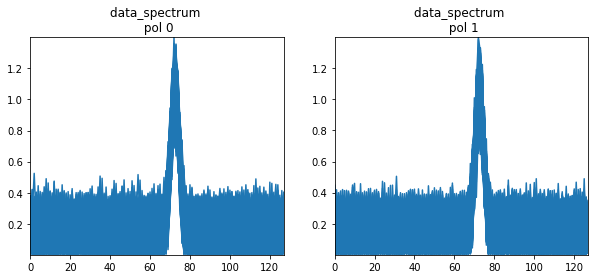

uv-cont result (no noise), polynomial order 1


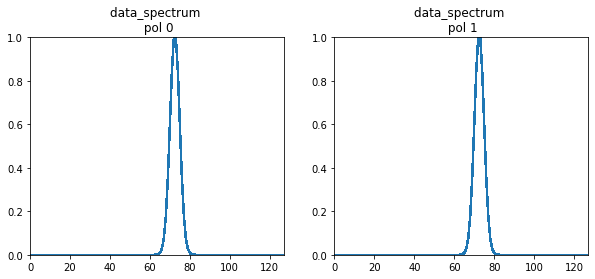

uv-cont result, polynomial order 1


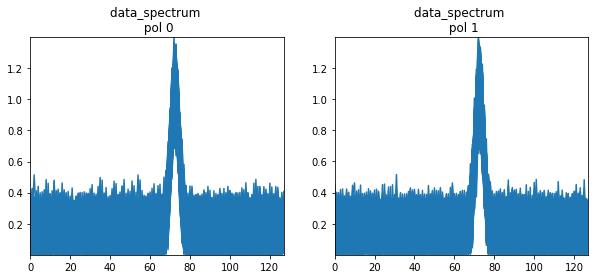

uv-cont result, polynomial order 2


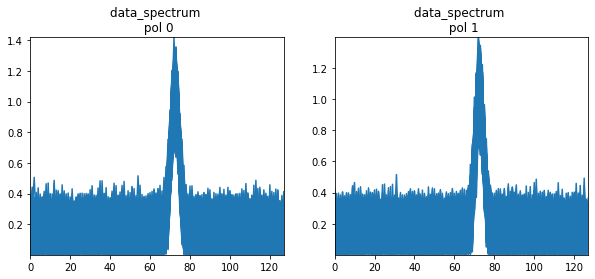

uv-cont result, polynomial order 3


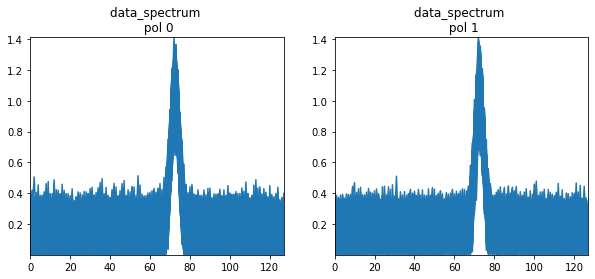

In [573]:
try:
  from casatasks import uvcontsub2021
  fitspw='0:0~59;86~127'
  ms_uvcont = 'uvcont_noise_sub_0.ms'
  res = uvcontsub2021(vis='sim_alma_cont_poly_order_0_noise.ms', outputvis=ms_uvcont, 
                fitorder=0, fitspw=fitspw)
  print(res)
  print('uv-cont result, polynomial order 0')
  plot_ms_data(ms_uvcont, 'data_spectrum')

  ms_uvcont = 'uvcont_nonoise_sub_1.ms'
  res = uvcontsub2021(vis='sim_alma_cont_poly_order_1_nonoise.ms', outputvis=ms_uvcont, 
                      fitorder=1, fitspw=fitspw)
  print('uv-cont result (no noise), polynomial order 1')
  plot_ms_data(ms_uvcont, 'data_spectrum')

  ms_uvcont = 'uvcont_noise_sub_1.ms'
  res = uvcontsub2021(vis='sim_alma_cont_poly_order_1_noise.ms', outputvis=ms_uvcont, 
                      fitorder=1, fitspw=fitspw)
  print('uv-cont result, polynomial order 1')
  plot_ms_data(ms_uvcont, 'data_spectrum')

  ms_uvcont = 'uvcont_noise_sub_2.ms'
  res = uvcontsub2021(vis='sim_alma_cont_poly_order_2_noise.ms', outputvis=ms_uvcont, 
                      fitorder=2, fitspw=fitspw)
  print('uv-cont result, polynomial order 2')
  plot_ms_data(ms_uvcont, 'data_spectrum')

  ms_uvcont = 'uvcont_noise_sub_3.ms'
  res = uvcontsub2021(vis='sim_alma_cont_poly_order_3_noise.ms', outputvis=ms_uvcont, 
                      fitorder=3, fitspw=fitspw)
  print('uv-cont result, polynomial order 3')
  plot_ms_data(ms_uvcont, 'data_spectrum')

except ImportError as exc:
  print('Import error, most likely related to casatasks/tools not yet including '
        f'new uvcontsub: {exc}')